# Import and Class Section

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import cv2
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch.backends.cudnn as cudnn

np.set_printoptions(threshold=np.inf)
sys.path.append("../libs")

from nms import nms
from tqdm import tqdm
from track.KCF import Tracker
from collections import deque
from torch.autograd import Variable
from networks.Pelee.configs.CC import Config
from networks.Pelee.data import BaseTransform
from scipy.optimize import linear_sum_assignment
from networks.Pelee.utils.core import anchors, init_net
from networks.Pelee.layers.functions import Detect, PriorBox

from networks.Pelee.peleenet import build_net as build_net
from networks.Pelee.peleenet_reduced import build_net as build_net_reduced

In [ ]:
def plot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
class Average(object):
    def __init__(self):
        self.values = []
    
    def get(self):
        return sum(self.values) / len(self.values)
    
    def add(self, value):
        self.values.append(value)
        
class Timer(object):
    def __init__(self):
        self.time = 0
        self.start_time = 0
        self.end_time = 0
        
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        self.end_time = time.time()
    
    def get(self):
        return self.end_time - self.start_time

In [ ]:
class PeleeNet(object):
    def __init__(self, cfg_path, weight_path, thr):
        cfg = Config.fromfile(cfg_path)
        anchor_config = anchors(cfg.model)
        priorbox = PriorBox(anchor_config)
        if 'reduced' in cfg_path:
            self.net = build_net_reduced('test', cfg.model.input_size, cfg.model)
        else:
            self.net = build_net('test', cfg.model.input_size, cfg.model)
        init_net(self.net, cfg, weight_path)
        self.net.eval()
        self.num_classes = cfg.model.num_classes
        self.thresh = thr
        self.nms_threshold = 0.45
        self.softmax = torch.nn.Softmax(dim=-1)
        self.img = None
        
        with torch.no_grad():
            self.priors = priorbox.forward()
            if cfg.test_cfg.cuda:
                self.net = self.net.cuda()
                self.priors = self.priors.cuda()
                cudnn.benchmark = True
            else:
                self.net = self.net.cpu()

        self.detector = Detect(self.num_classes, cfg.loss.bkg_label, anchor_config)
        self.t = BaseTransform(cfg.model.input_size, cfg.model.rgb_means)
        
    def predict(self, image, center=False):
        with torch.no_grad():
            self.img = Variable(self.t(image).unsqueeze(0)).cuda()
            w, h = image.shape[1], image.shape[0]

            out_ = self.net(self.img)
            np.savetxt("conf_torch.txt", out_[1].cpu().numpy())
            np.savetxt("loc_torch.txt", out_[0].cpu().numpy())
            
            loc = out_[0].view(1, -1, 4)
            conf = self.softmax(out_[1].view(-1, self.num_classes))
            
            out = (loc, conf)
            scale = torch.Tensor([w, h, w, h]).cuda()
            boxes, scores = self.detector.forward(out, self.priors)
            boxes = (boxes[0] * scale).cpu().numpy()
            scores = scores[0].cpu().numpy()
            all_boxes = [np.array([]) for _ in range(self.num_classes)]
            
            for j in range(1, self.num_classes):
                inds = np.where(scores[:, j] > self.thresh)[0]
                if len(inds) == 0:
                    all_boxes[j] = np.empty([0, 5], dtype=np.float)
                    continue
                c_bboxes = boxes[inds]
                c_scores = scores[inds, j]
                c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float, copy=False)
                keep = nms(c_dets, self.nms_threshold)
                keep = keep[:50]
                c_dets = c_dets[keep, :]
                all_boxes[j] = c_dets.astype(np.float)
                
            if center:
                return self.to_center(all_boxes[1])
            else:
                return all_boxes[1]
            
    def to_center(self, bboxes):
        centers = []
        whs = []
        for bbox in bboxes:
            cx, cy = int((bbox[0] + bbox[2])/2), int((bbox[1] + bbox[3])/2)
            hw, hh = int((bbox[2] - bbox[0])/2), int((bbox[3] - bbox[1])/2)
            whs.append([hw, hh])
            centers.append([cx, cy])
        return np.array(centers), np.array(whs)

# Setup Section

In [4]:
video_name = "../archives/videos/B3S27.mp4"
ROOT = "../archives/weights/PeleeNet"
cfg_name = "vehicle_reduced.py"
folder = "ptm_peleenet_reduced"
name = "Final_Pelee_Gauge_size304.pth"
thr = 0.5

interpolate_frames = 9
timer = Timer()

NameError: name 'Timer' is not defined

In [ ]:
pure_ml_outputs = []
ml_interp_outputs = []

# Detection

In [3]:
cfg_path = os.path.join(ROOT, "configs", cfg_name)
weight_path = os.path.join(ROOT, folder, name)
pelee = PeleeNet(cfg_path, weight_path, thr)

NameError: name 'ROOT' is not defined

[ 83.56902313  41.33018112 198.51020813 154.57774353   0.9610126 ]


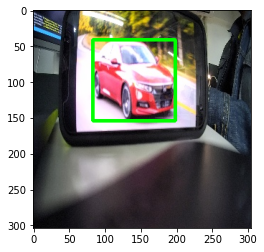

In [78]:
image_path = "../archives/images/from_board.jpg"
frame = cv2.imread(image_path)
bboxes = pelee.predict(frame)
for box in bboxes:
    startX = int(box[0])
    startY = int(box[1])
    endX = int(box[2])
    endY = int(box[3])
    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 3)
    print(box)
plot(frame)

[101.68018341 103.32707214 209.15380859 217.08528137   0.98422724]


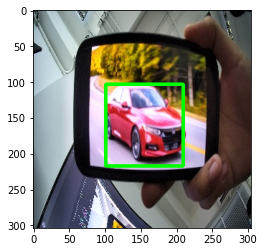

In [75]:
image_path = "../archives/images/from_board_car.jpg"
frame = cv2.imread(image_path)
bboxes = pelee.predict(frame)
for box in bboxes:
    startX = int(box[0])
    startY = int(box[1])
    endX = int(box[2])
    endY = int(box[3])
    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 3)
    print(box)
plot(frame)

# Detection + Interpolate Tracking

In [ ]:
video = cv2.VideoCapture(video_name)
detected_video = cv2.VideoCapture("detection_pure.mp4")
writer = cv2.VideoWriter("detection_interpolate.mp4", cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 60, (1920, 1080))
comp_writer = cv2.VideoWriter("compare.mp4", cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 60, (1920, 1080))

cfg_path = os.path.join(ROOT, "configs", cfg_name)
weight_path = os.path.join(ROOT, folder, name)
pelee = PeleeNet(cfg_path, weight_path, thr)

det_times = Average()
tracking_times = Average()
init_track_times = Average()

c = interpolate_frames
first = True
while video.isOpened():
    ret, frame = video.read()
    _, det_frame = detected_video.read()
    if ret:
        if c < interpolate_frames and not first:
            c += 1
            bboxes = []
            
            timer.start()
            for tracker in trackers:
                box = tracker.update(frame)
                bboxes.append(box)
            timer.stop()
            tracking_times.add(timer.get())
        else:
            c = 0
            first = False
            trackers = []
            timer.start()
            bboxes = pelee.predict(frame)
            timer.stop()
            det_times.add(timer.get())
            
            if np.any(bboxes):
                timer.start()
                for box in bboxes:
                    box = box.astype(np.int)[: 4].tolist()
                    trackers.append(Tracker(frame, box))
                timer.stop()
                init_track_times.add(timer.get())
        for box in bboxes:
            if type(box) != bool:
                startX = int(box[0])
                startY = int(box[1])
                endX = int(box[2])
                endY = int(box[3])
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.rectangle(det_frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
        ml_interp_outputs.append(bboxes)
        writer.write(frame)
        comp_writer.write(det_frame)
    else:
        writer.release()
        comp_writer.release()
        video.release()
        detected_video.release()
        break
print(f"Detection take {det_times.get()} seconds")
print(f"Initial trackers take {init_track_times.get()} seconds")
print(f"Tracking take {tracking_times.get()} seconds")

# Test